# 2. Solving a Simple Linear Regression Model with a Mock Dataset, using Gradient Descent

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression

### Mock dataset generation

As in notebook 1, will be skipped.

In [2]:
# All helper functions
min_surf = 40
max_surf = 150
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this will return the price in millions of SGD.
    return round((100000 + 14373*surface)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def get_x_list(l):
    return [v[0] for v in l]
def get_y_list(l):
    return [v[1] for v in l]

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
np.random.seed(47)
n_points = 50
dataset = [(s := surface(min_surf, max_surf), price(s)) for _ in range(n_points)]
inputs = get_x_list(dataset)
outputs = get_y_list(dataset)
print(inputs)
print(outputs)

[52.48, 120.16, 117.84, 111.01, 117.66, 68.16, 50.86, 110.49, 60.4, 69.8, 144.99, 122.2, 134.25, 100.83, 96.39, 99.06, 41.17, 112.21, 121.94, 79.8, 100.16, 59.21, 55.42, 91.91, 56.01, 98.04, 57.56, 51.41, 82.49, 101.82, 112.81, 144.95, 136.82, 67.77, 88.92, 138.32, 125.19, 92.96, 88.72, 106.9, 147.58, 131.88, 93.71, 140.88, 84.07, 110.61, 101.99, 74.49, 134.29, 134.95]
[0.935365, 1.772784, 1.901195, 1.666587, 1.700371, 0.976882, 0.797843, 1.628048, 1.048909, 1.053269, 2.021069, 1.672687, 2.109117, 1.684086, 1.389638, 1.460845, 0.744834, 1.864293, 1.766388, 1.25355, 1.465289, 0.924532, 0.876662, 1.554265, 0.907612, 1.450346, 0.945283, 0.850319, 1.17885, 1.60976, 1.61443, 1.990804, 2.183792, 1.165802, 1.344189, 2.19417, 2.043345, 1.379503, 1.38291, 1.644736, 2.266497, 1.830034, 1.562736, 2.004551, 1.320158, 1.680886, 1.593864, 1.231054, 2.020608, 2.105278]


### Linear Regression

As explained in notebook 1.

Linear regression is a model, which assumes that there is a linear relationship between inputs $ x $ and outputs $ y $. It therefore consists of two parameters $ (a, b) $, to be chosen, which will connect any input $ x_i $ to its respective output $ y_i $, with the equation:

$$ y_i \approx a x_i + b $$

Below, we define the **linreg()** function, which produces a list of values to be used for display later, to represent the linear function $ f(x) = ax + b $ in matplotlib, for any parameters a and b.

In [4]:
# Linear regression has two trainable parameters (a and b).
# Other parameters, like min_surf, max_surf, n_points will
# help get points for the upcoming matplotlib displays.
def linreg(a, b, min_surf, max_surf, n_points = 50):
    return [(x, a*x + b) for x in np.linspace(min_surf, max_surf, n_points)]

### Loss function

As explained in Notebook 1.

In order to measure the quality of the fit for each model, and evaluate whether the parameters $ (a, b) $ used for the linear regression are good choices or not, we will use a loss function, namely the mean square error  $ L(a, b, x, y) $:

$$ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 $$

With $ N $ being the number of points in the dataset (i.e. the value in the variable *n_points*).

As a rule of thumb, the lower the value of this loss function, the better the model fits the data.

We implement the loss function below, as the function **loss_mse()**.

In [5]:
# Mean square error as a loss function
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse(a, b, x, y):
    val =  sum([(y_i - (a*x_i + b))**2 for x_i, y_i in zip(x, y)])/len(x)
    return '{:.2e}'.format(val)

Below, we provide a full display with dataset entries, the three linear regressions and their loss values.

### Recap: Finding the optimal linear regression parameters, analytically

As explained in Notebook 1.

The best values $ (a^* , b^*) $ to be used for $ (a, b) $ can be found by solving the following optimization problem.

For any dataset of given inputs $ x = (x_i)_{i \in \{1, 2, ..., N\}} $ and outputs $ y = (y_i)_{i \in \{1, 2, ..., N\}} $, the best values $ (a^* , b^*) $ are defined as:

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ L(a, b, x, y) \right] $$

Or, equivalently:

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 \right] $$

Let us define the matrix notations, below:

$$ W = \begin{pmatrix} b \\ a \end{pmatrix}, $$

$$ X = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{pmatrix}, $$

$$ Y = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{pmatrix}, $$

Using these notations, we can prove that the optimal values $ (a^*, b^*) $, or equivalently $ W^* $, can be calculated as

$$ W^* = (X^T X)^{-1} X^T Y $$

(**Proof:** is out of scope, but for those of you who are curious, have a look at these lectures notes, https://people.cs.pitt.edu/~milos/courses/cs2750-Spring03/lectures/class6.pdf.)

In [6]:
# Defining W_star according to our formula
X = np.array([[1, x_i] for x_i in inputs])
XT = np.transpose(X)
Y = np.array([[y_i] for y_i in outputs])
W_star = np.matmul(np.linalg.inv(np.matmul(XT,X)), np.matmul(XT,Y))
print(W_star)
b_star, a_star = W_star[0, 0], W_star[1, 0]
print("Optimal a_star value: ", a_star)
print("The value we used for a in the mock dataset generation: ", 14373/1000000)
print("Optimal b_star value: ", b_star)
print("The value we used for b in the mock dataset generation: ", 100000/1000000)

[[0.14344691]
 [0.01387623]]
Optimal a_star value:  0.013876226287449462
The value we used for a in the mock dataset generation:  0.014373
Optimal b_star value:  0.14344690597884088
The value we used for b in the mock dataset generation:  0.1


As in Notebook 1, we provide a display, showing the optimal linear regression model, in dashed magenta, below.

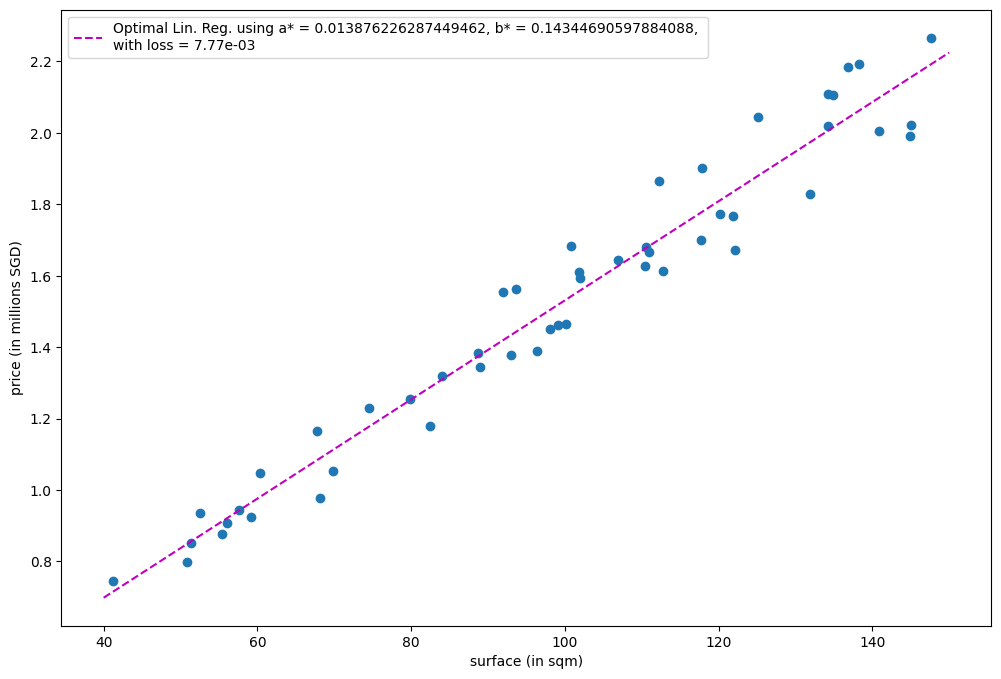

In [7]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal linreg
linreg_dataset1 = linreg(a_star, b_star, min_surf, max_surf, n_points)
loss1 = loss_mse(a_star, b_star, inputs, outputs)
legend1 = "Optimal Lin. Reg. using a* = {}, b* = {}, \nwith loss = {}".format(a_star, b_star, loss1)
plt.plot(get_x_list(linreg_dataset1), get_y_list(linreg_dataset1), 'm--', label = legend1)

# Display
plt.legend(loc = 'best')
plt.show()

### Using Gradient Descent to Compute the Optimal Linear Regression Parameters

The formula $ W^* = (X^T X)^{-1} X^T Y $, while being the correct analytical one, suffers from one major issue.

It relies on huge matrices $ X $ and $ Y $, and requires inverting a matrix, which can prove to be costly, especially when the number of entries in the dataset, *n_points*, grows large.

As such, it is often preferable to find a heuristic way to approximate the $ W^* $ parameters.

The typical approach consists of using gradient descent on the loss function $ L(a, b, x, y) = \frac{1}{N} \sum_{i=1}^N \left((a x_i + b) - y_i\right)^2 $ we defined earlier, to find the optimal parameters for the linear regression model.

Gradient descent, is therefore a non-analytical way to solve the optimization problem we defined earlier, i.e.: 

$$ (a^* , b^*) = \arg\min_{(a, b)} \left[ L(a, b, x, y) \right]. $$

For this loss function, we have the following partial derivatives, with respect to $ a $ and $ b $:
$$ D_a = \frac{\partial L}{\partial a}  = \frac{-2}{N} \sum_{i = 1}^{N} x_i (y_i - (a x_i + b)) $$
$$ D_b = \frac{\partial L}{\partial b}  = \frac{-2}{N} \sum_{i = 1}^{N} (y_i - (a x_i + b)) $$

Our update rules for the gradient descent are therefore defined below, with $ \rho $ being the learning rate for the gradient descent, a parameter to be decided manually, later.
$$ a \leftarrow a - \rho D_a $$
$$ b \leftarrow b - \rho D_b $$

We will repeat these iterations, until a convergence is observed on both $ a $ and $ b $, and then return their final values, claiming that they are close enough to the analytical best values $ a^* $ and $ b^* $.

Our gradient descent approximator function, **gradient_descent_linreg()**, is implemented below.

In [8]:
def gradient_descent_linreg(a_0, b_0, x, y, rho = 1e-5, stop = 1e-5, max_count = 1000):
    # Define the initial values of a and b as a_0 and b_0
    a, b = a_0, b_0
    # Define N as the number of elements in the dataset
    N = len(x)
    # Keep track of how much a and b changed on each iteration
    change = float("Inf")
    # Counter as safety to prevent infinite looping
    counter = 0
    while change > stop:
        # Helper to visualize iterations of while loop
        print("-----")
        # Use gradident descent update rules for a and b
        D_a = -2/N*(sum([x_i*(y_i - (a*x_i + b)) for x_i, y_i in zip(x, y)]))
        D_b = 2/N*(sum([(y_i - (a*x_i + b)) for x_i, y_i in zip(x, y)]))
        a = a - rho*D_a
        b = b - rho*D_b
        print("Gradients: ", D_a, D_b)
        print("New values for (a, b): ", a, b)
        # Compute change
        change = max(abs(rho*D_a), abs(rho*D_b))
        print("Change: ", change)
        # Counter update, will break if iterations number exceeds max_count,
        # to prevent gradient descent from going indefinitely.
        # (Just a safety measure, for good practice, we would definitely prefer to see
        # the while loop break "naturally", because change eventually fell under the threshold stop.)
        counter += 1
        if(counter > max_count):
            print("Maximal number of iterations reached.")
            break
    return a, b

We then run the gradient descent, with the parameters $ \rho = 1e-5 $ and $ stop = 1e-6 $.

Feel free to try different values to see how it goes!

In [9]:
a_gd, b_gd = gradient_descent_linreg(a_0 = 0, b_0 = 0, x = inputs, y = outputs, rho = 1e-5, stop = 1e-6)

-----
Gradients:  -323.6032092932 3.0308010000000003
New values for (a, b):  0.0032360320929320004 -3.0308010000000006e-05
Change:  0.0032360320929320004
-----
Gradients:  -254.75770499202525 2.3909634523122776
New values for (a, b):  0.005783609142852253 -5.421764452312278e-05
Change:  0.002547577049920253
-----
Gradients:  -200.55886208737934 1.887249309606813
New values for (a, b):  0.007789197763726046 -7.309013761919091e-05
Change:  0.0020055886208737933
-----
Gradients:  -157.89065009563055 1.4906987517596286
New values for (a, b):  0.009368104264682351 -8.79971251367872e-05
Change:  0.0015789065009563057
-----
Gradients:  -124.2999640772044 1.1785130679851623
New values for (a, b):  0.010611103905454396 -9.978225581663882e-05
Change:  0.001242999640772044
-----
Gradients:  -97.85558934207354 0.9327439004808323
New values for (a, b):  0.011589659798875131 -0.00010910969482144714
Change:  0.0009785558934207355
-----
Gradients:  -77.03717096419676 0.739261347304396
New values for (

Using a final display, we can check that the values found by gradient descent are very close to the theoretical optimum, but they do not require heavy matrix computations.

Note that we could have approached the "optimal" magenta parameters, if we had kept the gradient descent going a bit longer (by lowering the learning rate **rho** and/or **stop** parameters). 

In [10]:
print("Optimal a_star value: ", a_star)
print("Value for a_star, found by gradient descent: ", a_gd)
print("We used 14373/1000000 in the mock dataset generation, which is: ", 14373/1000000)
print("Optimal b_star value: ", b_star)
print("Value for b_star, found by gradient descent: ", b_gd)
print("The value we used in the mock dataset generation: ", 100000/1000000)

Optimal a_star value:  0.013876226287449462
Value for a_star, found by gradient descent:  0.01520726846408737
We used 14373/1000000 in the mock dataset generation, which is:  0.014373
Optimal b_star value:  0.14344690597884088
Value for b_star, found by gradient descent:  -0.0001494858965301244
The value we used in the mock dataset generation:  0.1


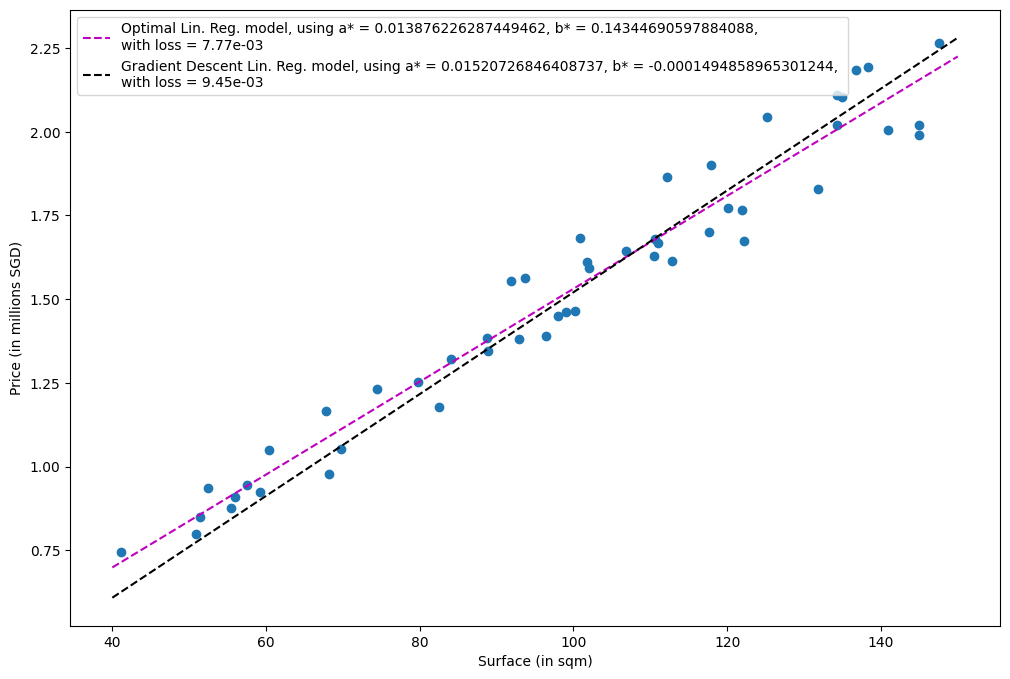

In [11]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal linreg
linreg_dataset = linreg(a_star, b_star, min_surf, max_surf, n_points)
loss = loss_mse(a_star, b_star, inputs, outputs)
legend = "Optimal Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_star, b_star, loss)
plt.plot(get_x_list(linreg_dataset), get_y_list(linreg_dataset), 'm--', label = legend)

# Gradient Descent linreg
linreg_dataset = linreg(a_gd, b_gd, min_surf, max_surf, n_points)
loss2 = loss_mse(a_gd, b_gd, inputs, outputs)
legend2 = "Gradient Descent Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_gd, b_gd, loss2)
plt.plot(get_x_list(linreg_dataset), get_y_list(linreg_dataset), 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### Linear Regression using the sklearn library 

In general, when a Linear Regressor is needed, we will import it from the *sklearn* library, instead of implementing it manually.

Refer to the documentation, here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

In [12]:
# Reshape inputs and outputs as a 2D np.array
# (as needed by the Linear Regression object)
sk_inputs = np.array(inputs).reshape(-1, 1)
print(sk_inputs.shape)
print(sk_inputs)
sk_outputs = np.array(outputs)
print(sk_outputs.shape)
print(sk_outputs)

(50, 1)
[[ 52.48]
 [120.16]
 [117.84]
 [111.01]
 [117.66]
 [ 68.16]
 [ 50.86]
 [110.49]
 [ 60.4 ]
 [ 69.8 ]
 [144.99]
 [122.2 ]
 [134.25]
 [100.83]
 [ 96.39]
 [ 99.06]
 [ 41.17]
 [112.21]
 [121.94]
 [ 79.8 ]
 [100.16]
 [ 59.21]
 [ 55.42]
 [ 91.91]
 [ 56.01]
 [ 98.04]
 [ 57.56]
 [ 51.41]
 [ 82.49]
 [101.82]
 [112.81]
 [144.95]
 [136.82]
 [ 67.77]
 [ 88.92]
 [138.32]
 [125.19]
 [ 92.96]
 [ 88.72]
 [106.9 ]
 [147.58]
 [131.88]
 [ 93.71]
 [140.88]
 [ 84.07]
 [110.61]
 [101.99]
 [ 74.49]
 [134.29]
 [134.95]]
(50,)
[0.935365 1.772784 1.901195 1.666587 1.700371 0.976882 0.797843 1.628048
 1.048909 1.053269 2.021069 1.672687 2.109117 1.684086 1.389638 1.460845
 0.744834 1.864293 1.766388 1.25355  1.465289 0.924532 0.876662 1.554265
 0.907612 1.450346 0.945283 0.850319 1.17885  1.60976  1.61443  1.990804
 2.183792 1.165802 1.344189 2.19417  2.043345 1.379503 1.38291  1.644736
 2.266497 1.830034 1.562736 2.004551 1.320158 1.680886 1.593864 1.231054
 2.020608 2.105278]


In [13]:
# Creating a sklearn Linear Regression model.
# It uses the same analytical formula from earlier, i.e. W^* = (X^T X)^{-1} X^T Y.
reg = LinearRegression().fit(sk_inputs, sk_outputs)
# The coefficients for a* and b* are found using coeff_ and intercept_ respectively.
a_sk = reg.coef_[0]
b_sk = reg.intercept_
print("Optimal a_star value: ", a_star)
print("Value for a_star, found by sklearn: ", a_sk)
print("Optimal b_star value: ", b_star)
print("Value for b_star, found by sklearn: ", b_sk)

Optimal a_star value:  0.013876226287449462
Value for a_star, found by sklearn:  0.013876226287449497
Optimal b_star value:  0.14344690597884088
Value for b_star, found by sklearn:  0.14344690597883836


### Using our model to predict on new unseen data

Eventually, we want to reuse the trained model, to predict the price of a new and unseen appartment with a given surface.

We can use the **predict()** method to do so, and verify that it produces a prediction which is acceptable (by comparing with our theoretical model).

In [14]:
# We can later use this Linear Regression model, to predict the price of
# a new appartment with surface 105 sqm (price in millions SGD).
new_surf = 105
pred_price = reg.predict(np.array([[new_surf]]))[0]
print(pred_price)

0.9066393517885607


According to our mockset formula, the price of this appartment, will most likely fall between 801463 and 979566, with an average value of 890515.

Our predicted price of 906639 SGD is therefore not too bad as an estimate.

In [15]:
avg_price = 14373*new_surf + 100000
min_val = 0.9*avg_price
max_val = 1.1*avg_price
print("Min, max, avg prices: ", [min_val, max_val, avg_price])

Min, max, avg prices:  [801463.5, 979566.5000000001, 890515]


### What's next?

In the next notebook, we will extend the concept of regression to polynomial functions, instead of simple linear ones.